In [1]:
from Bio import SeqIO
from Bio import motifs
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import click
from click_option_group import optgroup
import gc
import gzip
from io import StringIO
import numpy as np
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
bar_format = "{percentage:3.0f}%|{bar:20}{r_bar}"

In [2]:
from architectures import CAM
from jaspar import get_figure, reformat_jaspar_motif
from sequence import one_hot_encode, one_hot_decode, rc_one_hot_encoding

In [3]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [4]:
#model_file = "../results/SMS.published/CAM/CTCF.NA@snappy-grey-markhor/best_model.pth.tar"
#training_file = "../results/SMS.published/FASTA/Train/CTCF.NA@snappy-grey-markhor.fa.gz"
#output_dir = "../results/SMS.published/CAM/CTCF.NA@snappy-grey-markhor/"
#tf_name = "SOX2.NA"
model_file = "../results/Human-Mouse-Project/CAM/best_model.pth.tar"
training_file = "../results/Human-Mouse-Project/FASTA/train.fa.gz"
output_dir = "../results/Human-Mouse-Project/CAM/"
tf_name = "human-mouse"
batch_size = 2**6
debugging = False
threads = 1

In [5]:
# Create output dirs
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
for subdir in ["sites", "motifs", "logos"]:
    if not os.path.isdir(os.path.join(output_dir, subdir)):
        os.makedirs(os.path.join(output_dir, subdir))

In [6]:
# Load model
selene_dict = torch.load(model_file)
model = CAM(
    selene_dict["options"]["cnn_units"],
    selene_dict["options"]["kernel_size"],
    selene_dict["options"]["sequence_length"],
    selene_dict["options"]["n_features"],
    selene_dict["options"]["clamp_weights"],
    selene_dict["options"]["no_padding"],
    selene_dict["options"]["weights_file"],
)
model.load_state_dict(selene_dict["state_dict"])
model.to(device)

CAM(
  (linears): Sequential(
    (0): Conv1d(512, 128, kernel_size=(19,), stride=(1,), padding=(19,), groups=128)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpAct()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): UnSqueeze()
    (6): Conv1d(4864, 12800, kernel_size=(1,), stride=(1,), groups=128)
    (7): BatchNorm1d(12800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(12800, 128, kernel_size=(1,), stride=(1,), groups=128)
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=128, out_features=2, bias=True)
)

In [7]:
# Padding
if selene_dict["options"]["no_padding"]:
    padding = 0
else:
    padding = selene_dict["options"]["kernel_size"]

In [8]:
def _get_Xs_ys_record_ids(fasta_file, debugging=False, reverse_complement=False):

    # Initialize
    Xs = []
    ys = []
    record_ids = []

    # Xs / ys
    handle = __get_handle(fasta_file)
    for record in SeqIO.parse(handle, "fasta"):
        _, y_list = record.description.split()
        Xs.append(one_hot_encode(str(record.seq).upper()))
        ys.append([float(y) for y in y_list.split(";")])
        record_ids.append((record.id, "+"))

    # Reverse complement
    if reverse_complement:
        n = len(Xs)
        for i in range(n):
            Xs.append(rc_one_hot_encoding(Xs[i]))
            ys.append(ys[i])
            record_ids.append((record_ids[i][0], "-"))

    # Return 1,000 sequences
    if debugging:
        return(np.array(Xs)[:10000], np.array(ys)[:10000], 
               np.array(record_ids)[:10000])

    return(np.array(Xs), np.array(ys), np.array(record_ids))

def _get_data_loader(Xs_train, ys_train, batch_size=2**6, threads=1):

    # TensorDatasets
    train_set = TensorDataset(torch.Tensor(Xs_train), torch.Tensor(ys_train))

    # DataLoaders
    kwargs = dict(batch_size=batch_size, num_workers=threads)
    train_loader = DataLoader(train_set, **kwargs)

    return(train_loader)

def __get_handle(file_name):
    if file_name.endswith("gz"):
        handle = gzip.open(file_name, "rt")
    else:
        handle = open(file_name, "rt")
    return(handle)

In [9]:
# Get Xs/ys/record ids
Xs, ys, record_ids = _get_Xs_ys_record_ids(training_file, debugging, True)

# Get DataLoader
data_loader = _get_data_loader(list(Xs), list(ys), batch_size, threads)

# Input data
if np.unique(ys[:, 0]).size == 2:
    input_data = "binary"
else:
    input_data = "linear"
input_data

'binary'

In [11]:
# Initialize
sequences = []
outputs = []
labels = []

if padding:
    padded_sequence = one_hot_encode("N" * padding)

# Get sequences, outputs, and labels
with torch.no_grad():
    for x, label in tqdm(data_loader, total=len(data_loader)):
        for encoded_seq in x:
            if padding:
                sequences.append(
                    np.concatenate(
                        (padded_sequence, encoded_seq, padded_sequence),
                        axis=1
                    )
                )
            else:
                sequences.append(encoded_seq)
        x = x.to(device)
        out = model(x)
        if input_data == "binary":
            out = torch.sigmoid(out)
        outputs.extend(out.detach().cpu().numpy())
        labels.extend(label.numpy())

# To NumPy
sequences = np.array(sequences)
outputs = np.array(outputs)
labels = np.array(labels)

100%|██████████| 3983/3983 [02:21<00:00, 28.23it/s]


In [10]:
def __get_activations(model, data_loader):

    # Initialize
    activations = torch.tensor([], dtype=torch.float32)

    with torch.no_grad():
        for x, _ in tqdm(data_loader, total=len(data_loader)):
            x = x.to(device)
            x = x.repeat(1, model._options["cnn_units"], 1)
            activation = model.linears[:3](x)
            activations = torch.cat([activations, activation.cpu()])

    return(activations.numpy())

In [ ]:
# Get activations
activations = __get_activations(model, data_loader)
activations.shape

  2%|▏         | 68/3983 [00:08<11:42,  5.58it/s]

In [ ]:
# Get the indices of well predicted sequences
if input_data == "binary":
    indices = np.where((labels == 1.) & (outputs >= .5))[0]
else:
    labels_ixs = np.argsort(-labels.flatten())[:int(max(labels.shape) * .1)]
    outputs_ixs = np.argsort(-outputs.flatten())[:int(max(outputs.shape) * .1)]
    indices = np.intersect1d(labels_ixs, outputs_ixs)
indices.shape

In [233]:
# For each filter, get the activation thresholds (i.e. ≥50%)
act_thresholds = 0.5 * np.amax(activations[indices, :, :], axis=(0, 2))

In [234]:
def __get_filter_sites(indices, record_ids, sequences, activations,
                       threshold, kernel_size=19):
    """
    For each filter and for each sequence, get sites reaching at least
    ½ of the maximum activation value for that filter.
    """

    # Initialize
    sites = []

    # For each sequence...
    for i in indices:

        # Get start positions of sequence sites activating this filter
        starts = np.where(activations[i, :] > threshold)

        # Decode the sequence
        sequence = one_hot_decode(sequences[i])

        # For each start...
        for j in starts[0]:

            # Get site
            s = Seq(sequence[j:j+kernel_size])
            seq_id = "%s_%s_from=%s_to=%s" % (record_ids[i][0], record_ids[i][1],
                                              j, j+kernel_size)
            sites.append(SeqRecord(s, id=seq_id, name="", description=""))

    return(sites)

In [235]:
# For each filter...
for i in tqdm(range(len(act_thresholds)), total=len(act_thresholds)):

    sites_file = os.path.join(output_dir, "sites", f"filter{i}.fa")
    if not os.path.exists(sites_file):

        # Get sites
        sites = __get_filter_sites(indices, record_ids, sequences,
                                   activations[:, i, :], act_thresholds[i],
                                   model._options["kernel_size"])

        # Save sites
        with open(sites_file, "w") as handle:
            SeqIO.write(sites, handle, "fasta")

100%|██████████| 16/16 [01:44<00:00,  6.52s/it]


In [236]:
def __get_motif_from_sites(sites_file):
    """
    From https://github.com/biopython/biopython/blob/master/Bio/motifs/__init__.py
    Read the motif from JASPAR .sites file.
    """
    alphabet = "ACGTN"
    instances = []
    pfm = {}

    with open(sites_file) as handle:
        for line in handle:
            if not line.startswith(">"):
                break
            # line contains the header ">...."
            # now read the actual sequence
            line = next(handle)
            instance = ""
            for c in line.strip():
                if c == c.upper():
                    instance += c
            instance = Seq(instance)
            instances.append(instance)

    instances = motifs.Instances(instances, alphabet)
    motif = motifs.Motif(alphabet=alphabet, instances=instances)

    for nt in alphabet[:-1]:
        pfm.setdefault(nt, motif.counts[nt])

    return(motifs.Motif(counts=pfm))

In [237]:
# For each filter...
for i in tqdm(range(len(act_thresholds)), total=len(act_thresholds)):

    motif_file = os.path.join(output_dir, "motifs", f"filter{i}.jaspar")
    if not os.path.exists(motif_file):

        # Get motif
        sites_file = os.path.join(output_dir, "sites", f"filter{i}.fa")
        motif = __get_motif_from_sites(sites_file)
        motif.matrix_id = f"filter{i}"
        motif.name = tf_name

        # Save motif
        with open(motif_file, "w") as handle:
            handle.write(format(motif, "jaspar"))

100%|██████████| 16/16 [00:00<00:00, 47.27it/s]


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


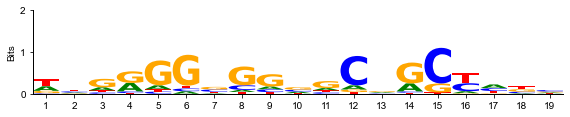

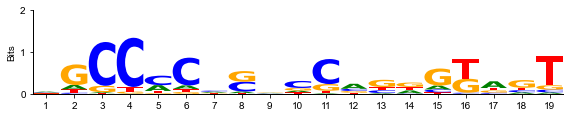

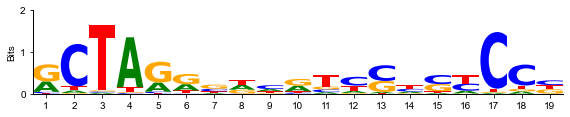

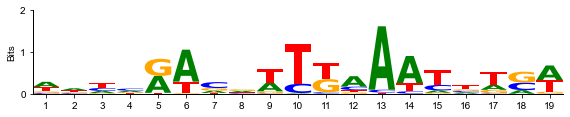

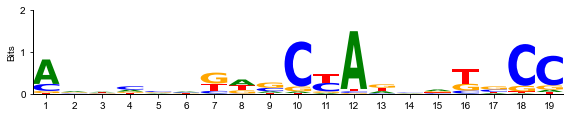

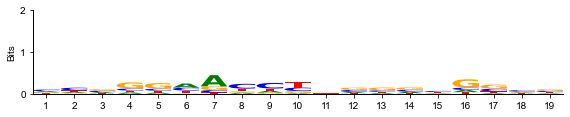

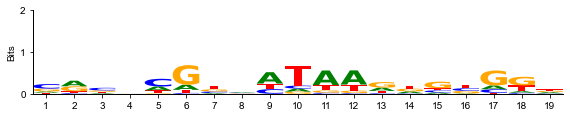

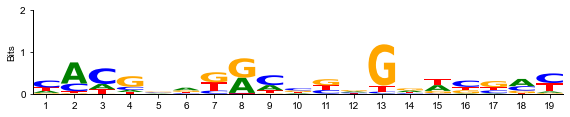

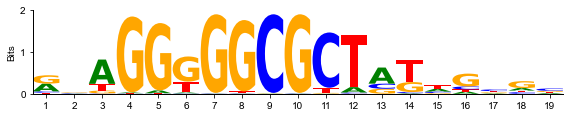

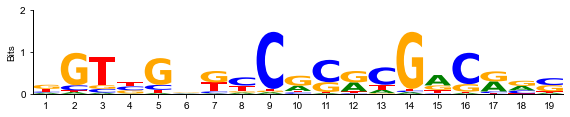

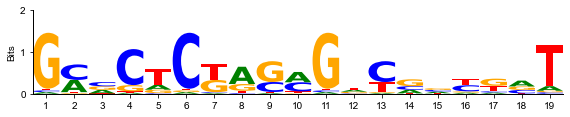

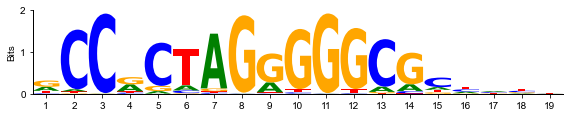

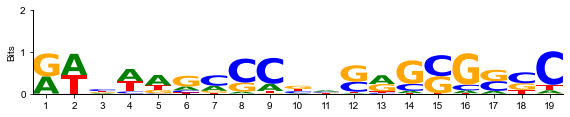

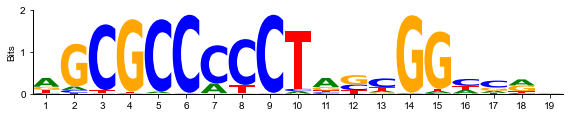

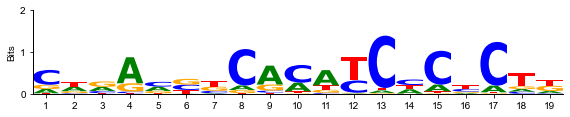

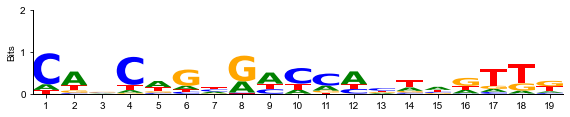

In [238]:
# For each filter...
for i in tqdm(range(len(act_thresholds)), total=len(act_thresholds)):

    logo_file = os.path.join(output_dir, "logos", f"filter{i}.png")
    if not os.path.exists(logo_file):

        # Save logo
        motif_file = os.path.join(output_dir, "motifs", f"filter{i}.jaspar")
        fig = get_figure(motif_file)
        fig.savefig(logo_file, bbox_inches="tight", pad_inches=0)

In [239]:
# Get weights
weights = model.final.weight.detach().cpu().numpy().flatten().tolist()
weights

[-0.1031881794333458,
 -0.1402064561843872,
 0.22732144594192505,
 -0.19721673429012299,
 0.22571168839931488,
 -0.15379509329795837,
 -0.1184791773557663,
 0.06189675256609917,
 0.1403285562992096,
 -0.25986969470977783,
 -0.18158677220344543,
 0.34837082028388977,
 0.20762021839618683,
 0.6868342161178589,
 -0.0949668288230896,
 -0.1952492594718933]

In [240]:
# Save weights
weights_file = os.path.join(output_dir, "filter-weights.tsv")
if not os.path.exists(weights_file):
    with open(weights_file, "w") as handle:
        for i, weight in enumerate(weights):
            handle.write(f"filter{i}\t{weight}\n")